In [1]:
from decouple import config
from fNeuro.MVPA.mvpa_functions import load_pickle, ados, extract, predictors_df, load_mvpa_predictors
from fNeuro.second_level.second_level_functions import bayes_factor_upper_bound
import os
import re
from nilearn.reporting import get_clusters_table
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiSpheresMasker
import nilearn.image as img 
import nilearn.plotting as nplot
from copy import deepcopy
import scipy
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Read in model and test images

In [3]:
img_dir = 'combined'
ml_dir = config('ml')
test_parameters = ados('G2' , test_train='test', directory=img_dir).reset_index(drop=True)
train_parameters = ados('G2', test_train='train', directory=img_dir).drop([20])
ml_models = {
    'space_net': load_pickle(os.path.join(ml_dir, 'spacenet_best_estimator', 'spacenet_models')),
    'frem_svr': dict(zip([re.sub('.pickle', '', key) for key in os.listdir(os.path.join(ml_dir, 'pickle', 'test_train_cv_10', img_dir))], 
                    [load_pickle(re.sub('\.pickle', '', os.path.join(os.path.join(ml_dir, 'frem_best_estimator'), pickle))) 
                     for pickle in os.listdir(os.path.join(ml_dir, 'frem_best_estimator'))])),

}

Unable to load pickle object


In [3]:
ados_df = pd.concat((test_parameters, train_parameters), axis=0)
ados_df.describe()

ADOS_Communication  ADOS_Interaction  ADOS_com_soc  ADOS_Creativity  \
count           39.000000         39.000000     39.000000        39.000000   
mean             1.230769          1.641026      2.871795         0.435897   
std              1.266191          1.798935      2.429853         0.552262   
min              0.000000          0.000000      0.000000         0.000000   
25%              0.000000          0.000000      1.000000         0.000000   
50%              1.000000          1.000000      2.000000         0.000000   
75%              2.000000          2.000000      4.000000         1.000000   
max              5.000000          7.000000      8.000000         2.000000   

       ADOS_sterotyped_and_repetititve  
count                        39.000000  
mean                          1.820513  
std                           1.393062  
min                           0.000000  
25%                           1.000000  
50%                           2.000000  
75%                           3.000000  
max                           5.000000

## Calculate performance metrics

In [4]:
%%capture
test_stats =  dict(zip([key for key in ml_models.keys()], [dict(zip([domain for domain in ml_models['space_net'].keys()],
                                                                    [{} for domain in ml_models['space_net'].keys()])) for key in ml_models.keys()]))

for algo in ml_models.keys():
    for model in ml_models['space_net'].keys():
        test_stats[algo][model]['y_pred'] = ml_models[algo][model].predict(test_parameters['paths']).ravel()
        test_stats[algo][model]['r2'] = ml_models[algo][model].score(test_parameters['paths'], test_parameters[model])
        test_stats[algo][model]['mse'] = np.mean(np.abs(test_parameters[model] - test_stats[algo][model]['y_pred']))

In [5]:
for model in test_stats['space_net'].keys():
      print(f"Mean square error for {model}:\n", 
            f"space net: {test_stats['space_net'][model]['mse']},",
            f"frem svr: {test_stats['frem_svr'][model]['mse']},")
      print(f"R2 {model}:\n ", 
            f"space net: {test_stats['space_net'][model]['r2']},",
            f"frem svr: {test_stats['frem_svr'][model]['r2']},",
            "\n")

Mean square error for ADOS_Communication:
 space net: 1.5179576179335816, frem svr: 1.5254718827409954,
R2 ADOS_Communication:
  space net: -0.1207494867083474, frem svr: 0.000138564595368873, 

Mean square error for ADOS_Interaction:
 space net: 0.9752964177246061, frem svr: 1.1526356722406348,
R2 ADOS_Interaction:
  space net: -3.0769316125458177, frem svr: -5.107014797231724, 

Mean square error for ADOS_com_soc:
 space net: 2.109020545306541, frem svr: 2.2932304787071978,
R2 ADOS_com_soc:
  space net: -0.14607408078028006, frem svr: -0.192828633319029, 

Mean square error for ADOS_Creativity:
 space net: 0.48402789315707095, frem svr: 0.858427903049831,
R2 ADOS_Creativity:
  space net: 0.02185386124858213, frem svr: -3.1790255567400125, 

Mean square error for ADOS_sterotyped_and_repetititve:
 space net: 1.2115227406610694, frem svr: 0.8420318912040441,
R2 ADOS_sterotyped_and_repetititve:
  space net: -0.4647679202058441, frem svr: 0.17674856299291808, 



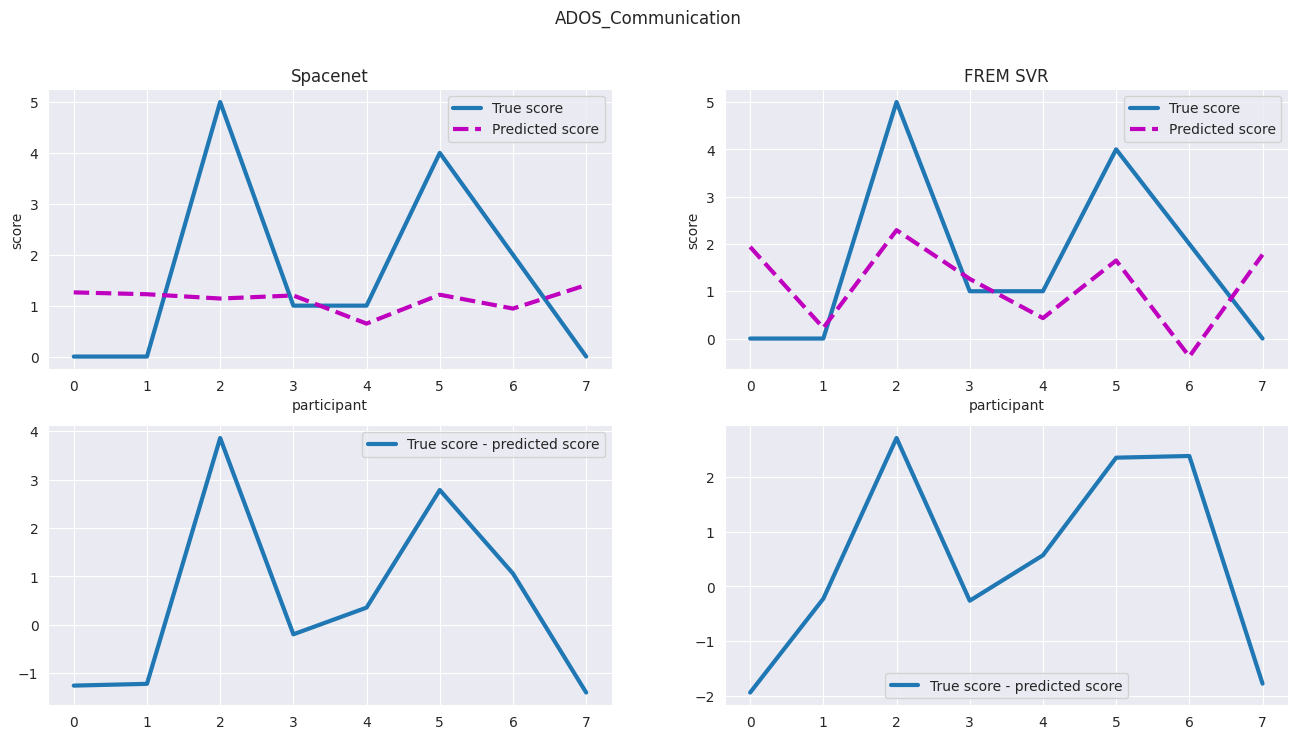

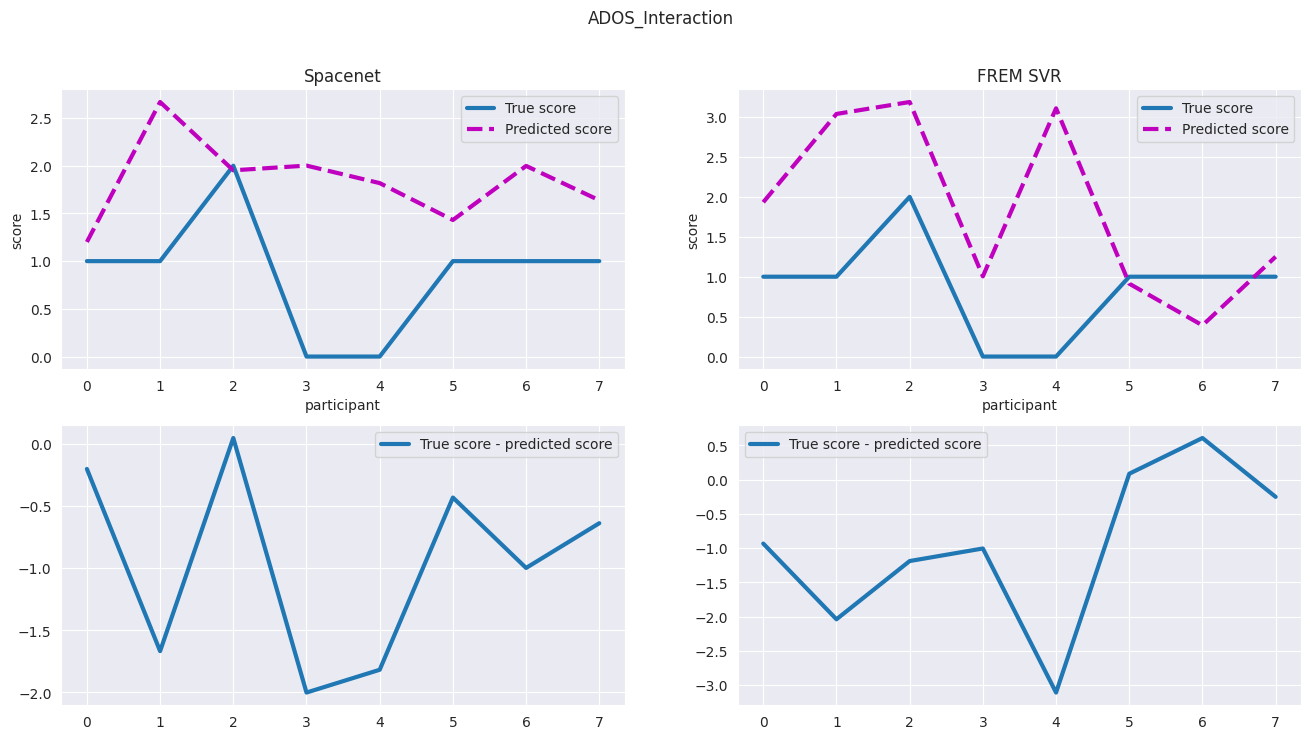

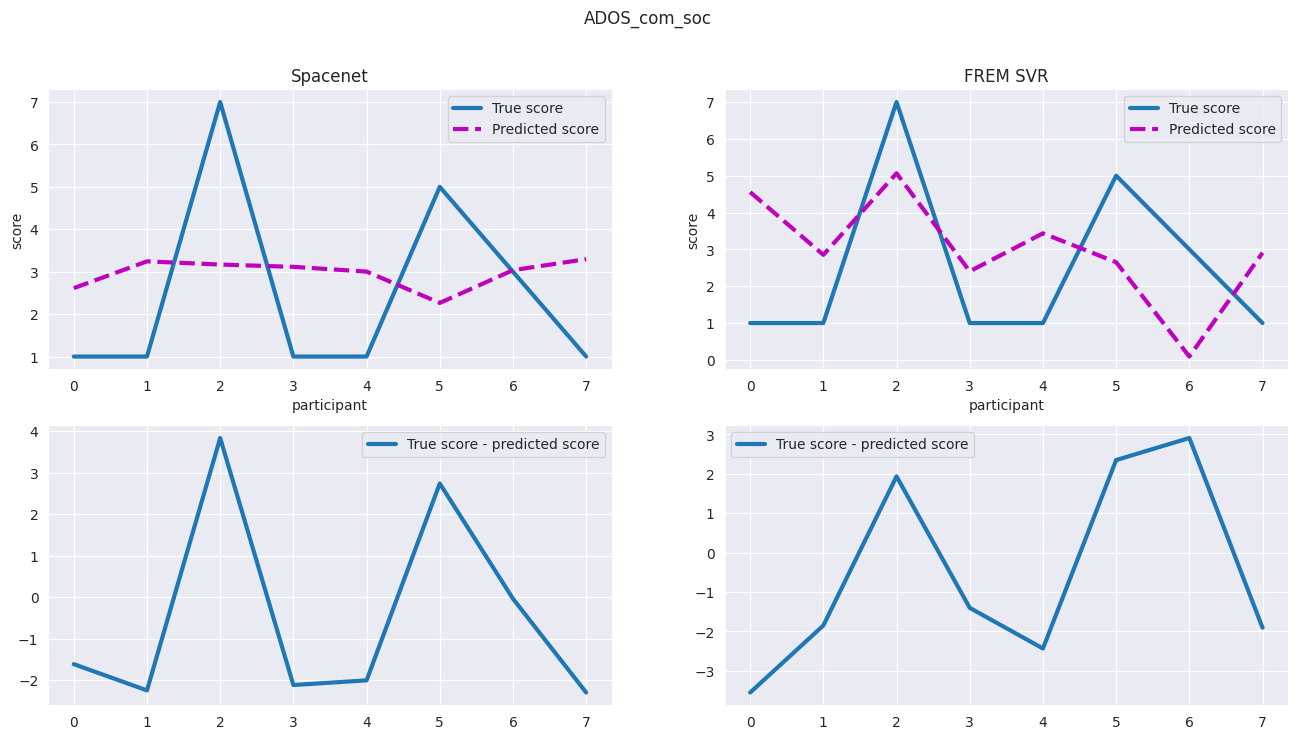

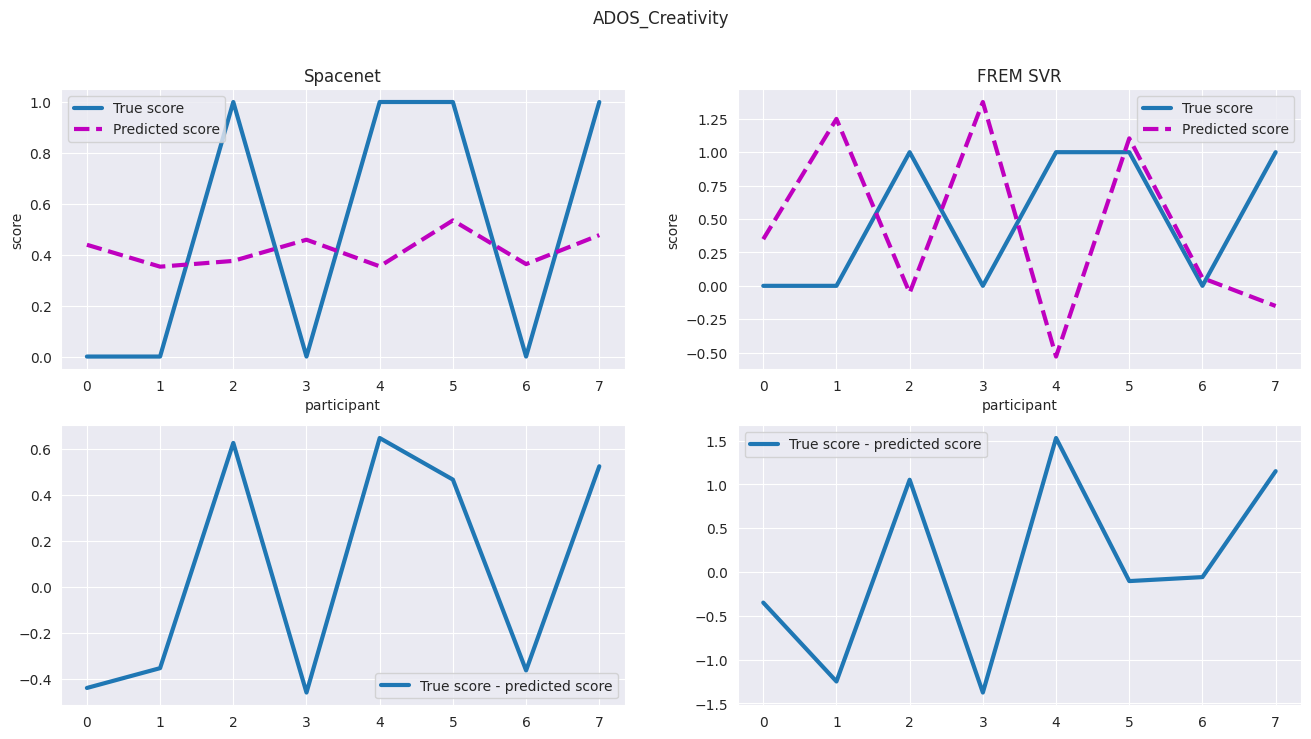

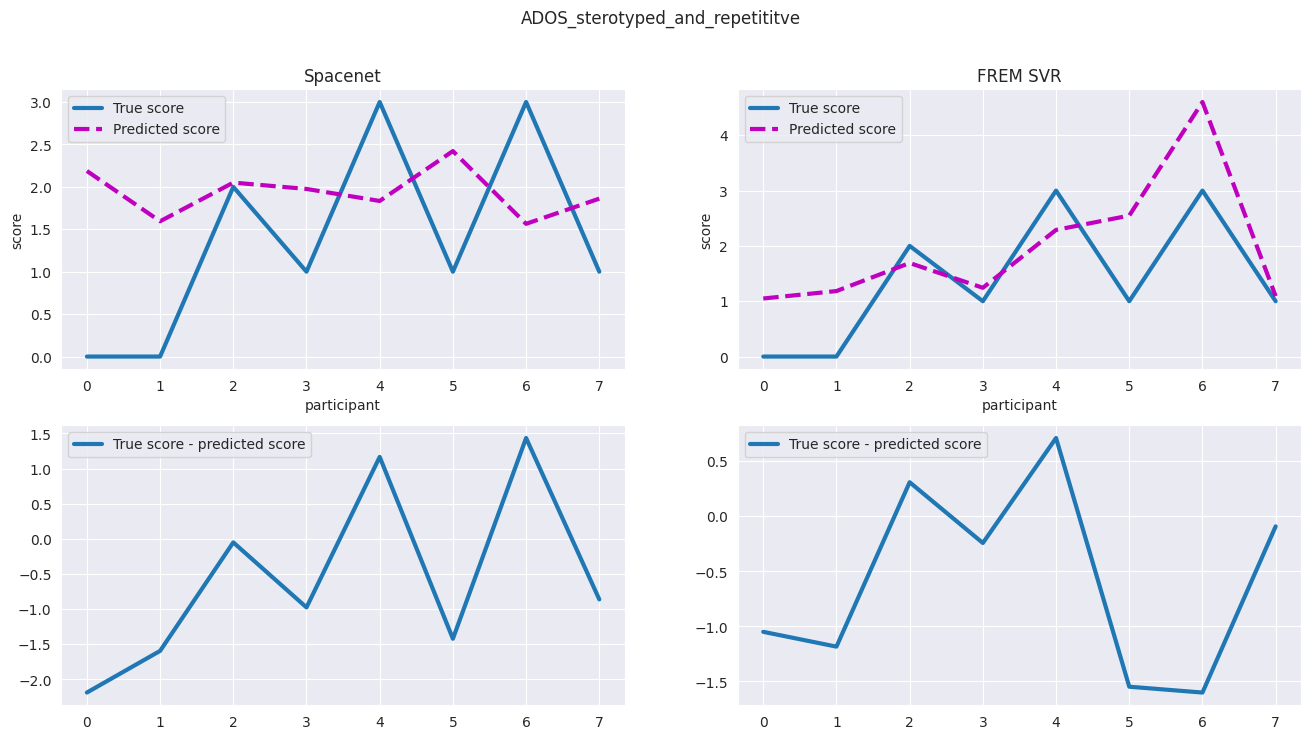

In [6]:
for model in test_stats['space_net'].keys():
    fig,ax = plt.subplots(2,2, figsize=(16,8))
    plt.suptitle(f"{model}")
    ax[0][0].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][1].plot(test_parameters[model], label="True score", linewidth=3)
    ax[0][0].plot(test_stats['space_net'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][1].plot(test_stats['frem_svr'][model]['y_pred'], "--", c="m", label="Predicted score", linewidth=3)
    ax[0][0].set_ylabel("score")
    ax[0][1].set_ylabel("score")
    ax[0][0].set_xlabel("participant")
    ax[0][1].set_xlabel("participant")
    ax[0][0].set_title('Spacenet')
    ax[0][1].set_title('FREM SVR')
    ax[0][0].legend(loc="best")
    ax[0][1].legend(loc="best")
    ax[1][0].plot(test_parameters[model] - test_stats['space_net'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][1].plot(test_parameters[model] - test_stats['frem_svr'][model]['y_pred'], label="True score - predicted score", linewidth=3)
    ax[1][0].legend(loc="best")
    ax[1][1].legend(loc="best")

## Plot weights for models with non-negative Rsquared

In [7]:
r2_models = {}
for algo in test_stats.keys():
    for model in test_stats['space_net'].keys():
        if test_stats[algo][model]['r2'] > 0:
            r2_models[f'{algo}_{model}'] = ml_models[algo][model]

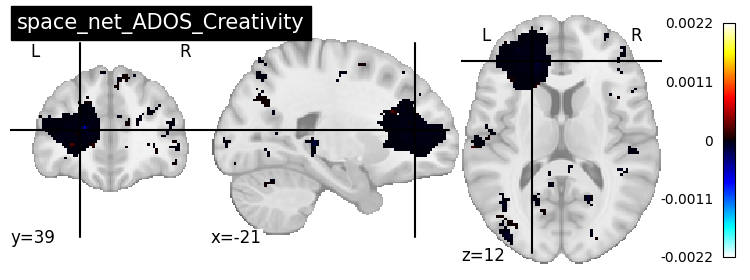

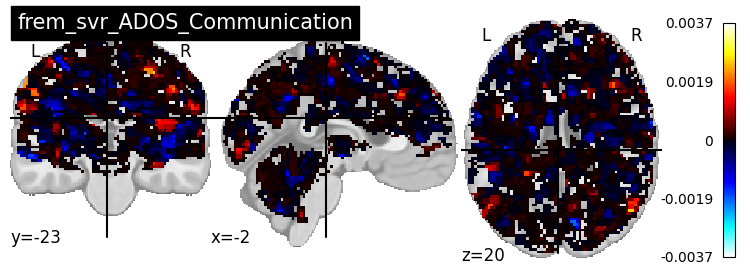

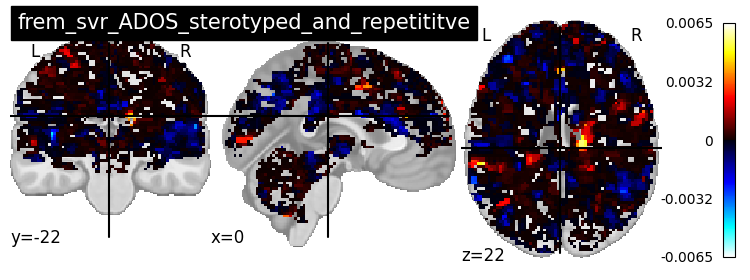

In [8]:
for model in r2_models.keys():
    img_r2 = r2_models[model].coef_img_
    if 'frem' in model:
        img_r2 = r2_models[model].coef_img_['beta']
    nplot.plot_stat_map(
        img_r2,
        title=model,
    )

## Examine Weights and weight distribution

In [9]:
frem_img_stereo = deepcopy(r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'])
frem_img_communication = deepcopy(r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'])
space_img = deepcopy(r2_models['space_net_ADOS_Creativity'].coef_img_)
frem_betas_stereo = pd.Series(frem_img_stereo.get_fdata().ravel()).describe()
frem_betas_communication = pd.Series(frem_img_communication.get_fdata().ravel()).describe()
space_betas = pd.Series(space_img.get_fdata().ravel()).describe()
display('FREM ADOS_sterotyped_and_repetititve', frem_betas_stereo)
display('FREM ADOS_Communication', frem_betas_communication)
display('SPACE NET ADOS_Creativity',space_betas) #ADOS_Communication

'FREM ADOS_sterotyped_and_repetititve'

count    1.082035e+06
mean    -3.328742e-07
std      2.111254e-04
min     -6.478027e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.570809e-03
dtype: float64

'FREM ADOS_Communication'

count    1.082035e+06
mean    -9.603574e-07
std      1.467375e-04
min     -3.419450e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.727159e-03
dtype: float64

'SPACE NET ADOS_Creativity'

count    1.082035e+06
mean    -3.552495e-07
std      1.091436e-05
min     -2.159546e-03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.271737e-04
dtype: float64

## Examine which weights are significant predictors

### For Spacenet model

In [10]:
t_score_spacenet = r2_models['space_net_ADOS_Creativity'].Xmean_ / r2_models['space_net_ADOS_Creativity'].Xstd_
p_value = scipy.stats.t.sf(np.abs(t_score_spacenet), df=163653-1 )*2
if p_value[p_value<0.05].size == 0:
    print('No significant predictors')

space_net_table = get_clusters_table(r2_models['space_net_ADOS_Creativity'].coef_img_, stat_threshold=0)

No significant predictors


### FREM model ADOS sterotyped and repetititve

In [11]:
t_score_img_frem_stereo = img.math_img("img_1/img_2",
    img_1=r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'],
    img_2 = r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].std_coef_img_['beta'])
p_value_img_frem_stereo = deepcopy(t_score_img_frem_stereo)
p_value_data_stereo = p_value_img_frem_stereo.get_fdata()
array_pvalues_stereo = scipy.stats.t.sf(np.abs(p_value_data_stereo), df=1082035-1)*2
pval_img_stereo = img.new_img_like(p_value_img_frem_stereo, array_pvalues_stereo)
neg_log_10_stereo = img.math_img("-np.log10(pval)", pval=pval_img_stereo)

<string>:1: RuntimeWarning: invalid value encountered in divide


#### plot T scores and p values


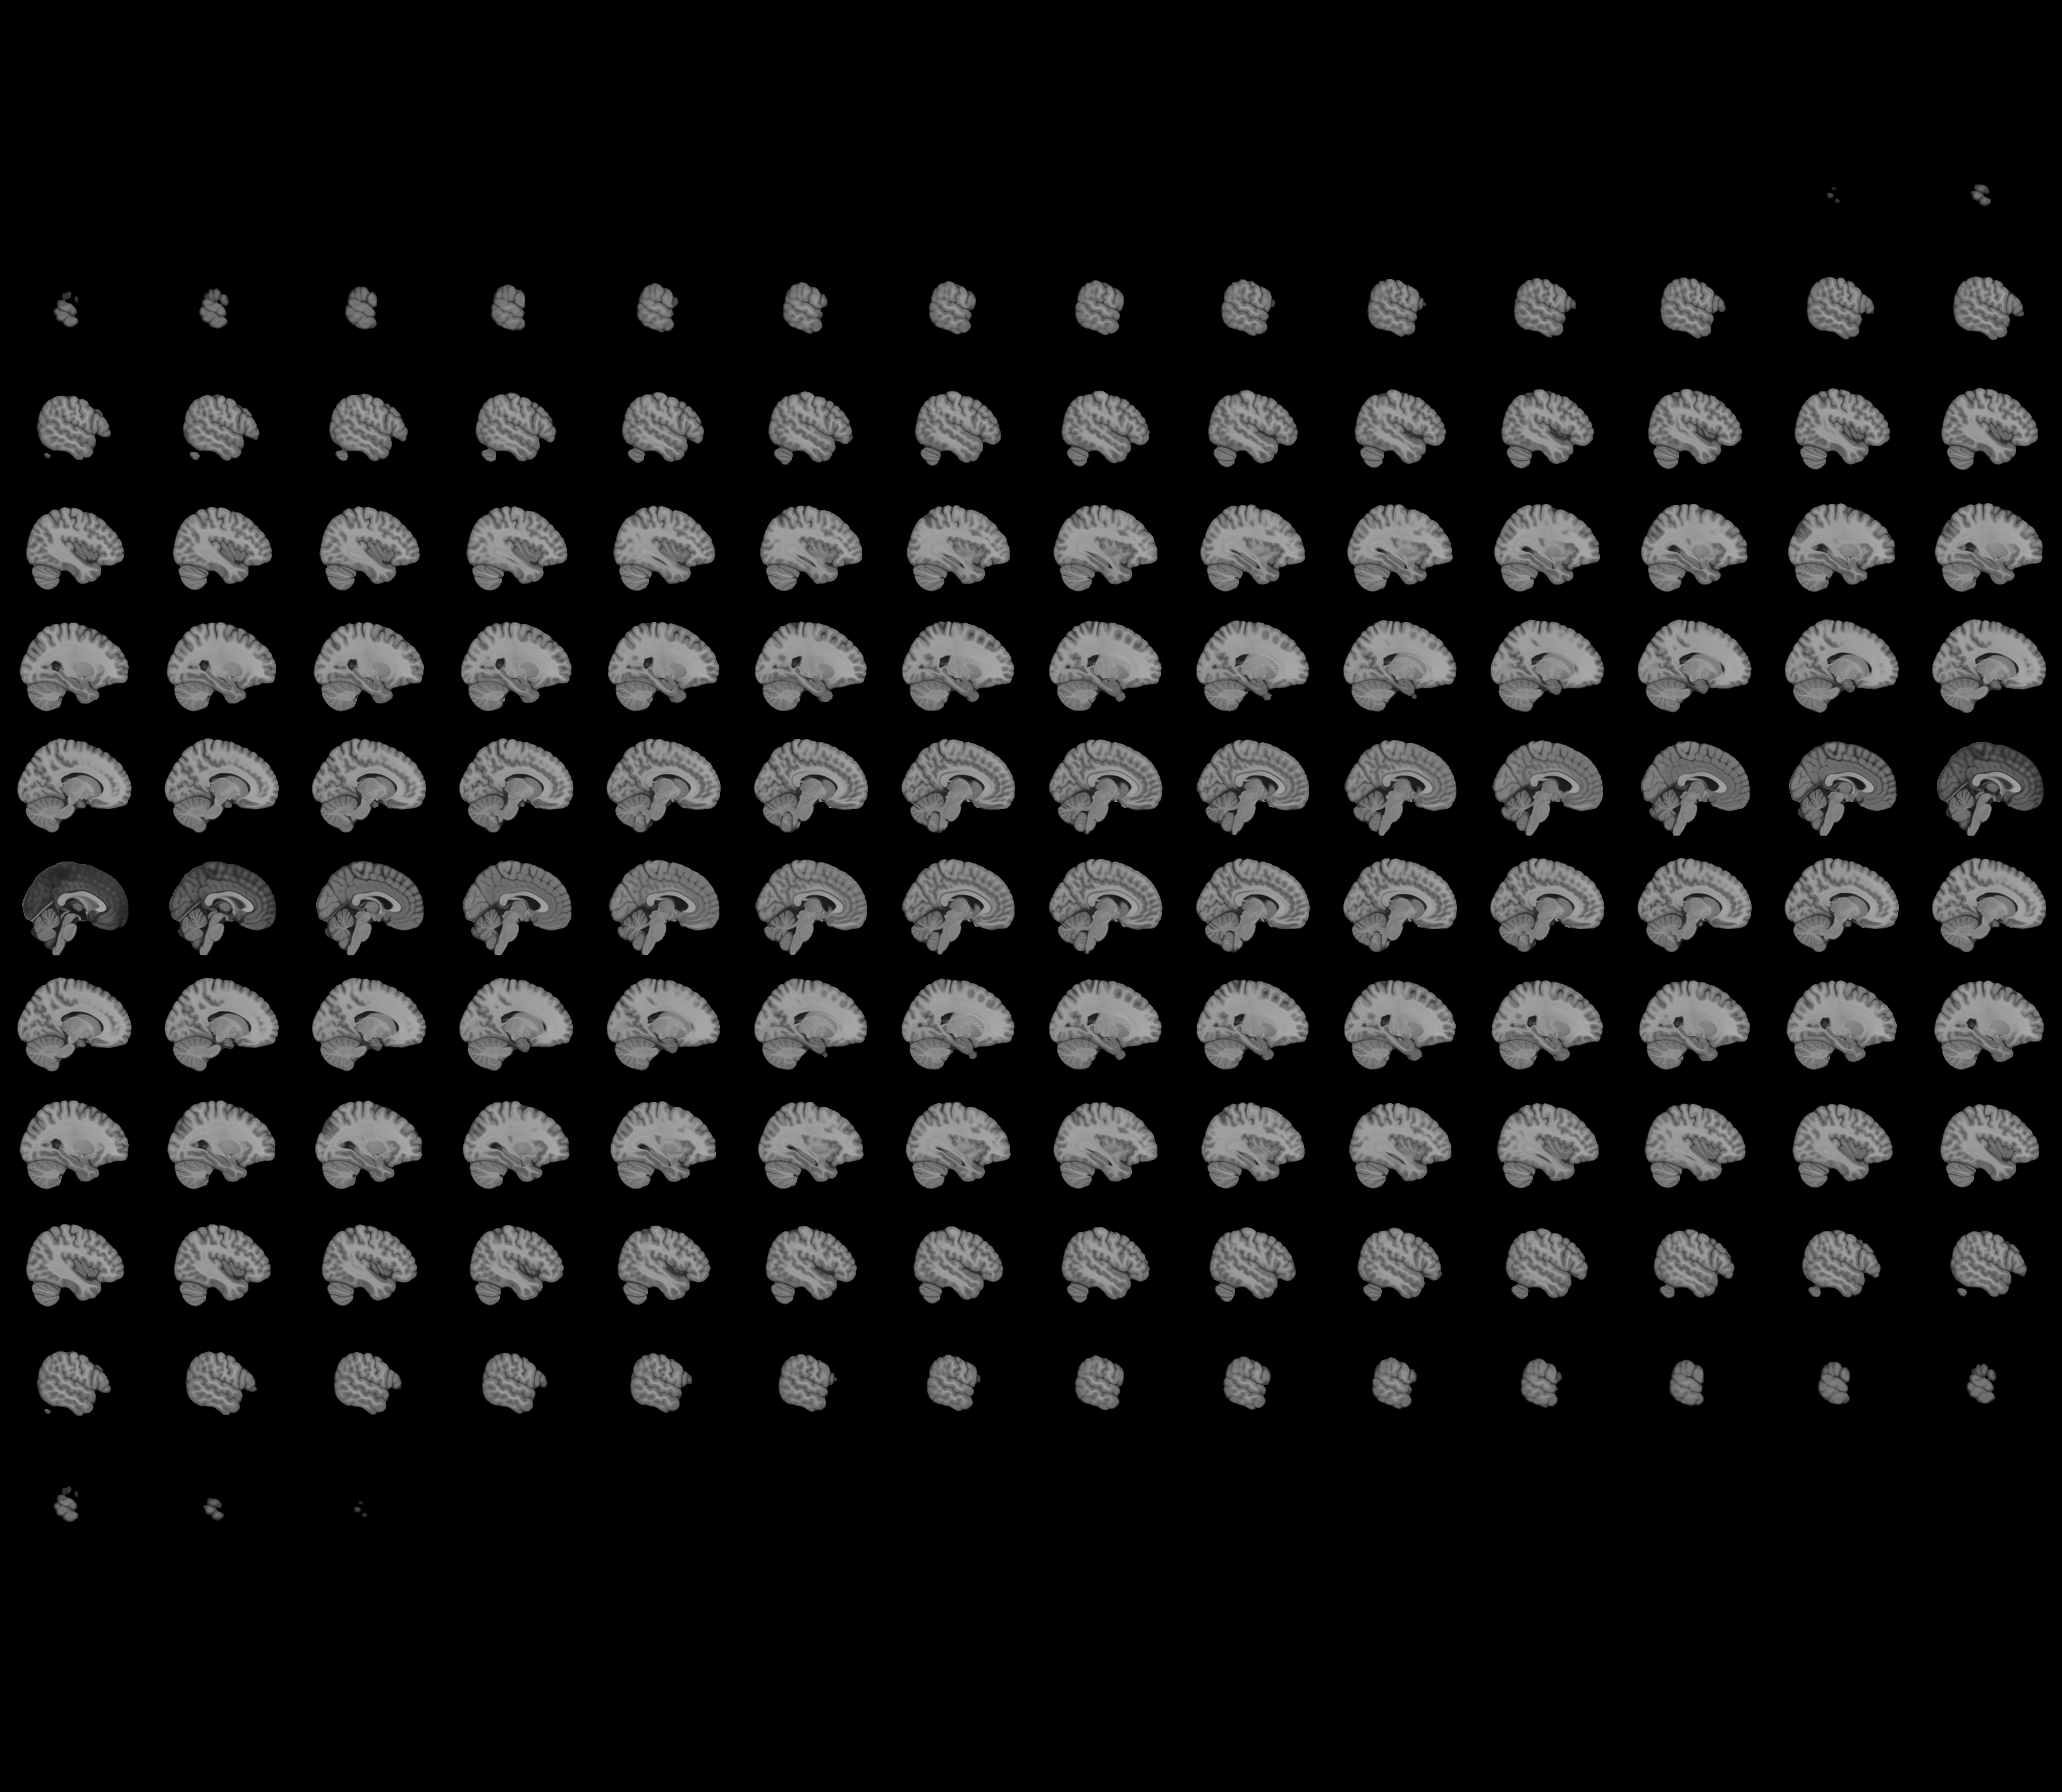
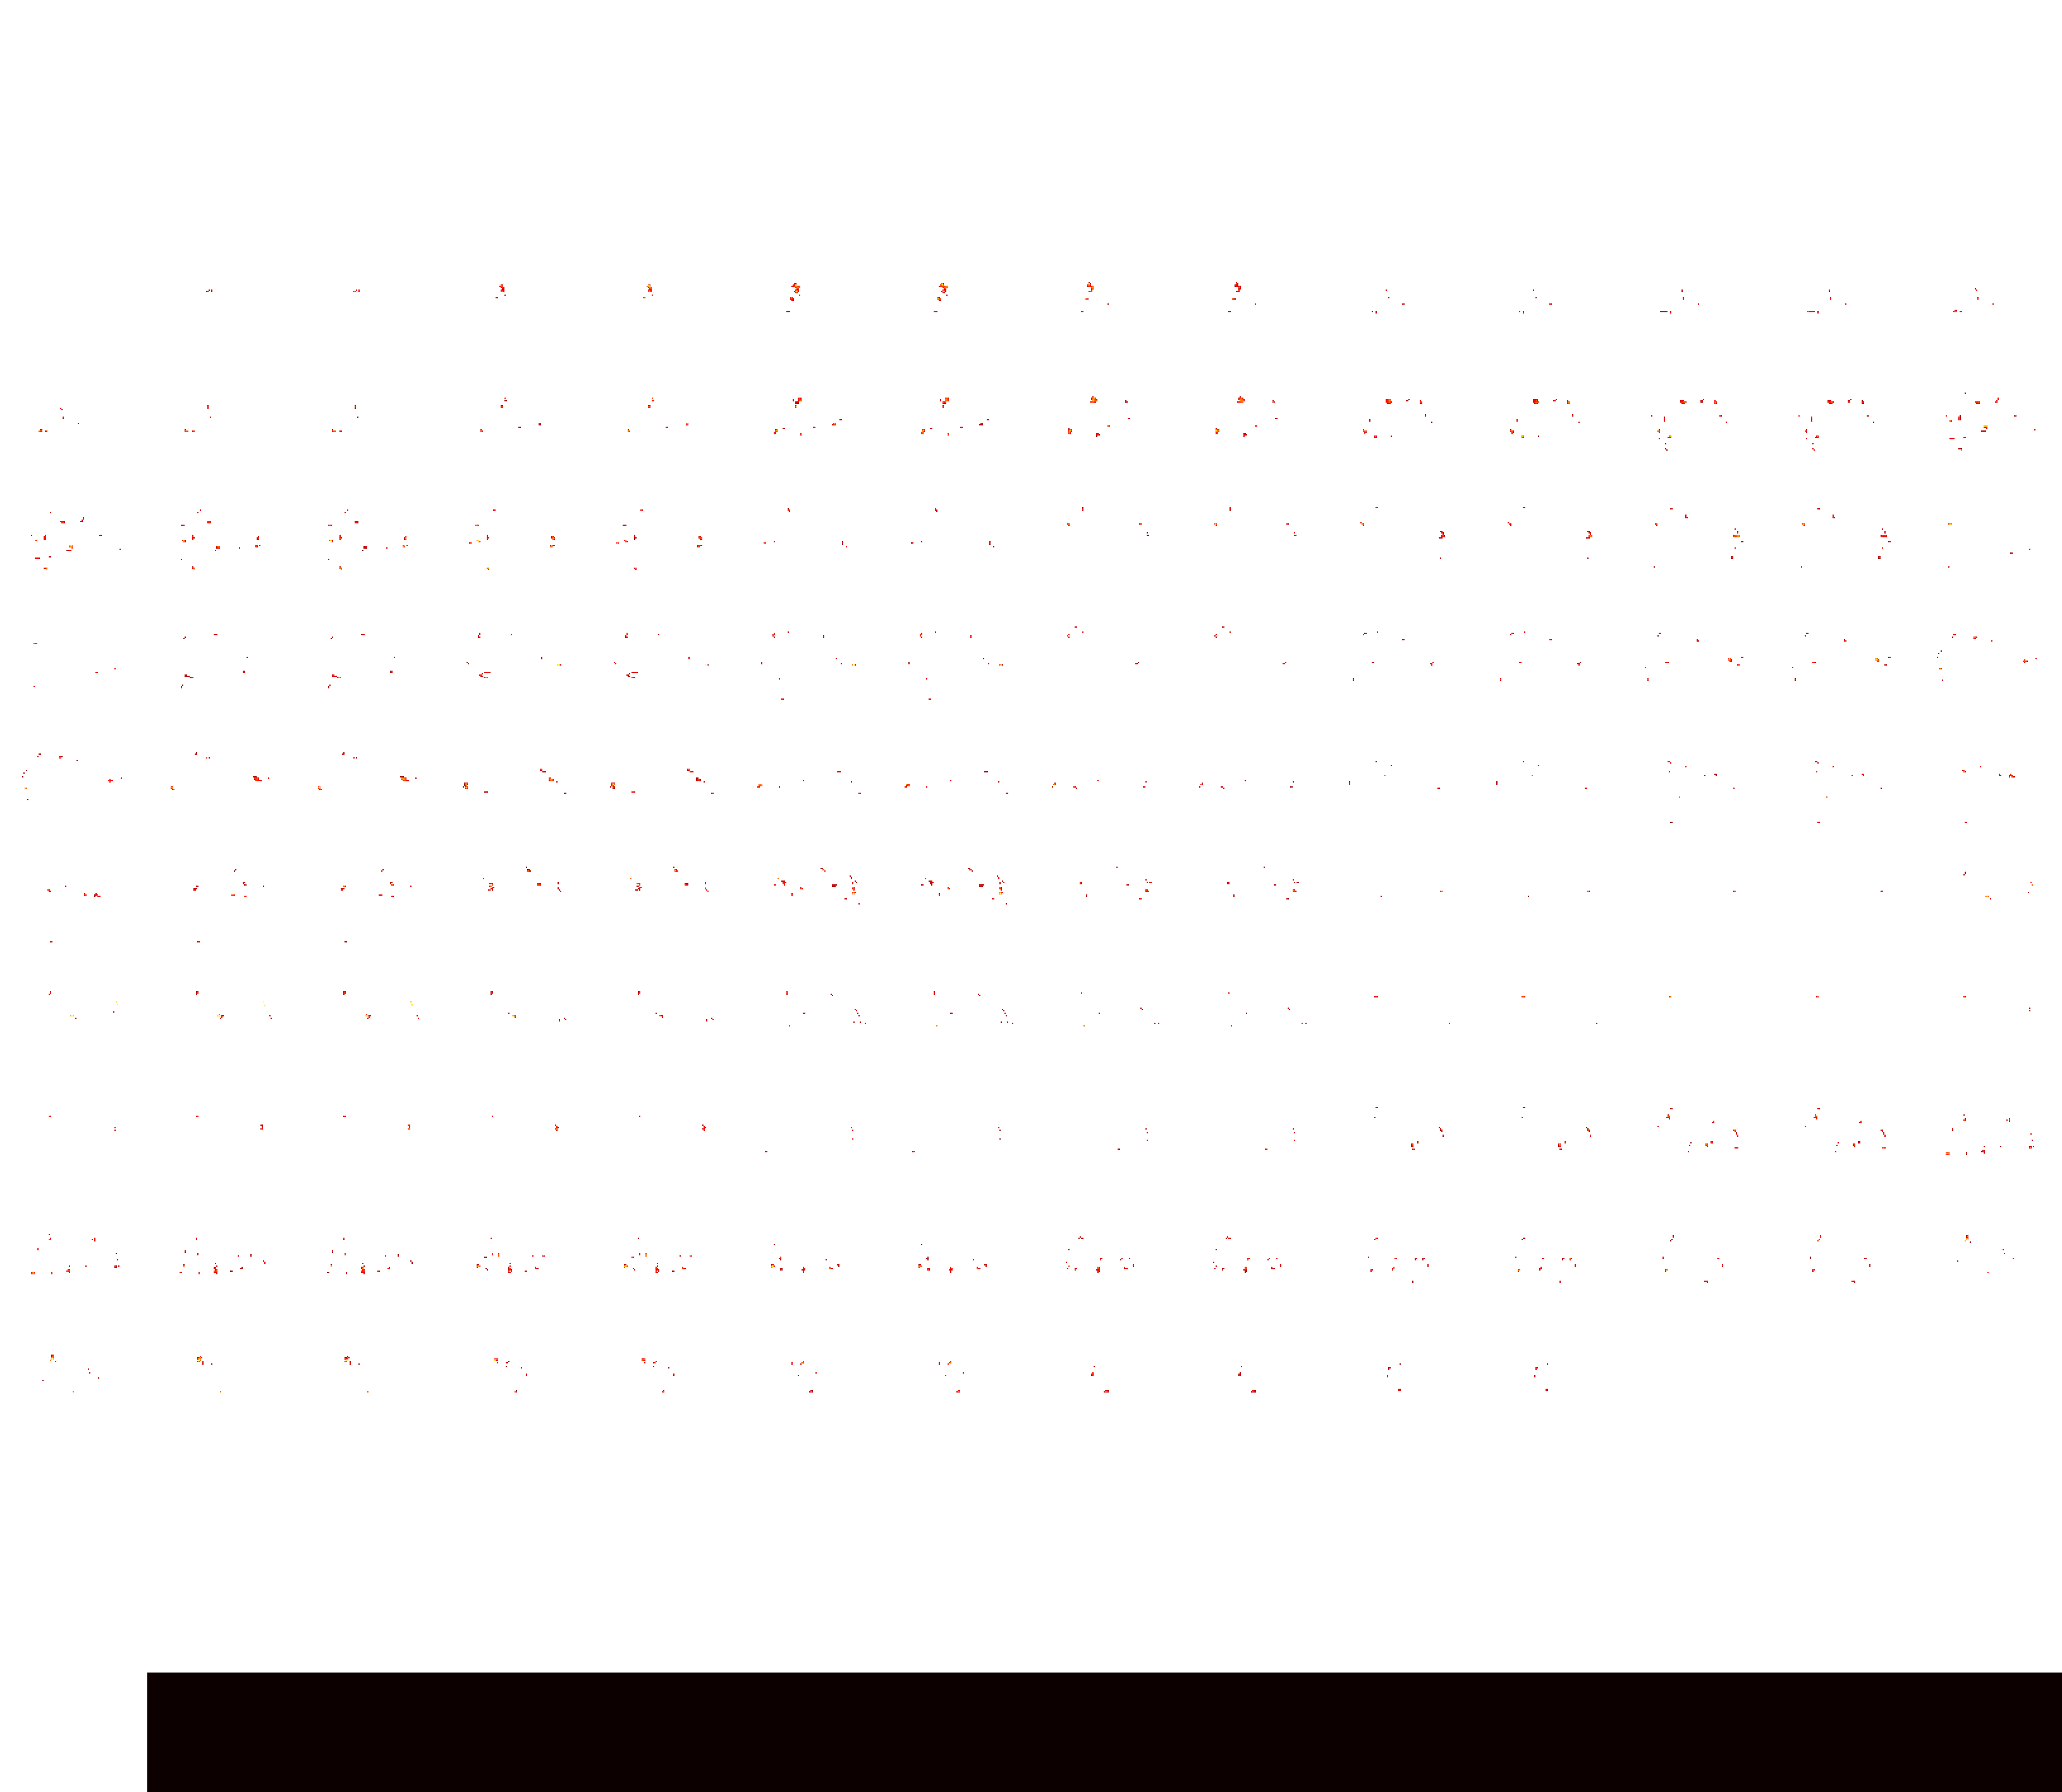

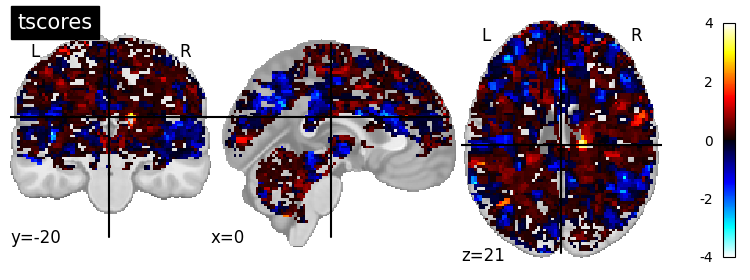

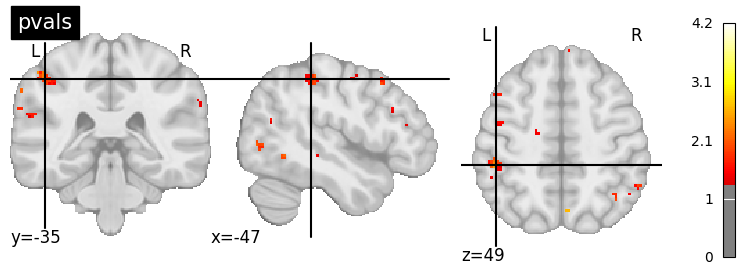

In [12]:
nplot.plot_stat_map(t_score_img_frem_stereo, title='tscores')
nplot.plot_stat_map(neg_log_10_stereo, threshold=-np.log10(0.05), title='pvals')
nplot.view_img(neg_log_10_stereo, threshold=-np.log10(0.05), title='pvals')

#### Extract regions that are signficant predictors

In [4]:
if 'frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv' in os.listdir(ml_dir):
    frem_predictors_df_stereo = load_mvpa_predictors(f'{ml_dir}/frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv')
else:
    frem_predictors_stereo = get_clusters_table(neg_log_10_stereo, stat_threshold=-np.log10(0.05))
    frem_predictors_stereo['pval'] = 10 ** -frem_predictors_stereo['Peak Stat'].values
    coords_stereo = frem_predictors_stereo[['X', 'Y', 'Z']]
    beta_t_stereo = extract(coords_stereo, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem_stereo)
    frem_predictors_df_stereo = pd.concat((frem_predictors_stereo, beta_t_stereo), axis=1).drop('Peak Stat', axis=1)
    frem_predictors_df_stereo = predictors_df(frem_predictors_df_stereo, frem_predictors_df_stereo[['X', 'Y', 'Z']])
    frem_predictors_df_stereo.to_csv(f'{ml_dir}/frem_svr_ADOS_sterotyped_and_repetititve_sig_predictors.csv')

In [5]:
frem_predictors_df_stereo.sort_values(by='BFB', ascending=False).head()

Cluster ID     X     Y     Z  Cluster Size (mm3)      beta      pval  \
83           2  15.5  49.5  43.5                16.0 -0.002219  0.000063   
82           1  15.5  51.5  39.5                24.0 -0.002219  0.000063   
65           3 -24.5  51.5   9.5                48.0 -0.002378  0.000088   
21           4  57.5 -52.5  43.5               232.0 -0.003108  0.000157   
260          5  15.5 -18.5  21.5               112.0  0.005571  0.000409   

            BFB        odds  null_proability               labels  
83   602.120160  603.120160           0.1658   Right Frontal Pole  
82   602.120160  603.120160           0.1658   Right Frontal Pole  
65   446.116548  447.116548           0.2237    Left Frontal Pole  
21   267.740244  268.740244           0.3721  Right Angular Gyrus  
260  115.405354  116.405354           0.8591            Caudate_R

### FREM ADOS Communication

In [15]:
t_score_img_frem_comms = img.math_img("img_1/img_2",
                                       img_1=r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'],
                                       img_2 = r2_models['frem_svr_ADOS_Communication'].std_coef_img_['beta'])
p_value_img_frem_comms = deepcopy(t_score_img_frem_comms)
p_value_data_comms = p_value_img_frem_comms.get_fdata()
array_pvalues_comms = scipy.stats.t.sf(np.abs(p_value_data_comms), df=1082035-1)*2
pval_img_comms = img.new_img_like(p_value_img_frem_comms, array_pvalues_comms)
neg_log_10_comms = img.math_img("-np.log10(pval)", pval=pval_img_comms)

<string>:1: RuntimeWarning: invalid value encountered in divide


#### Plot T scores and P-values


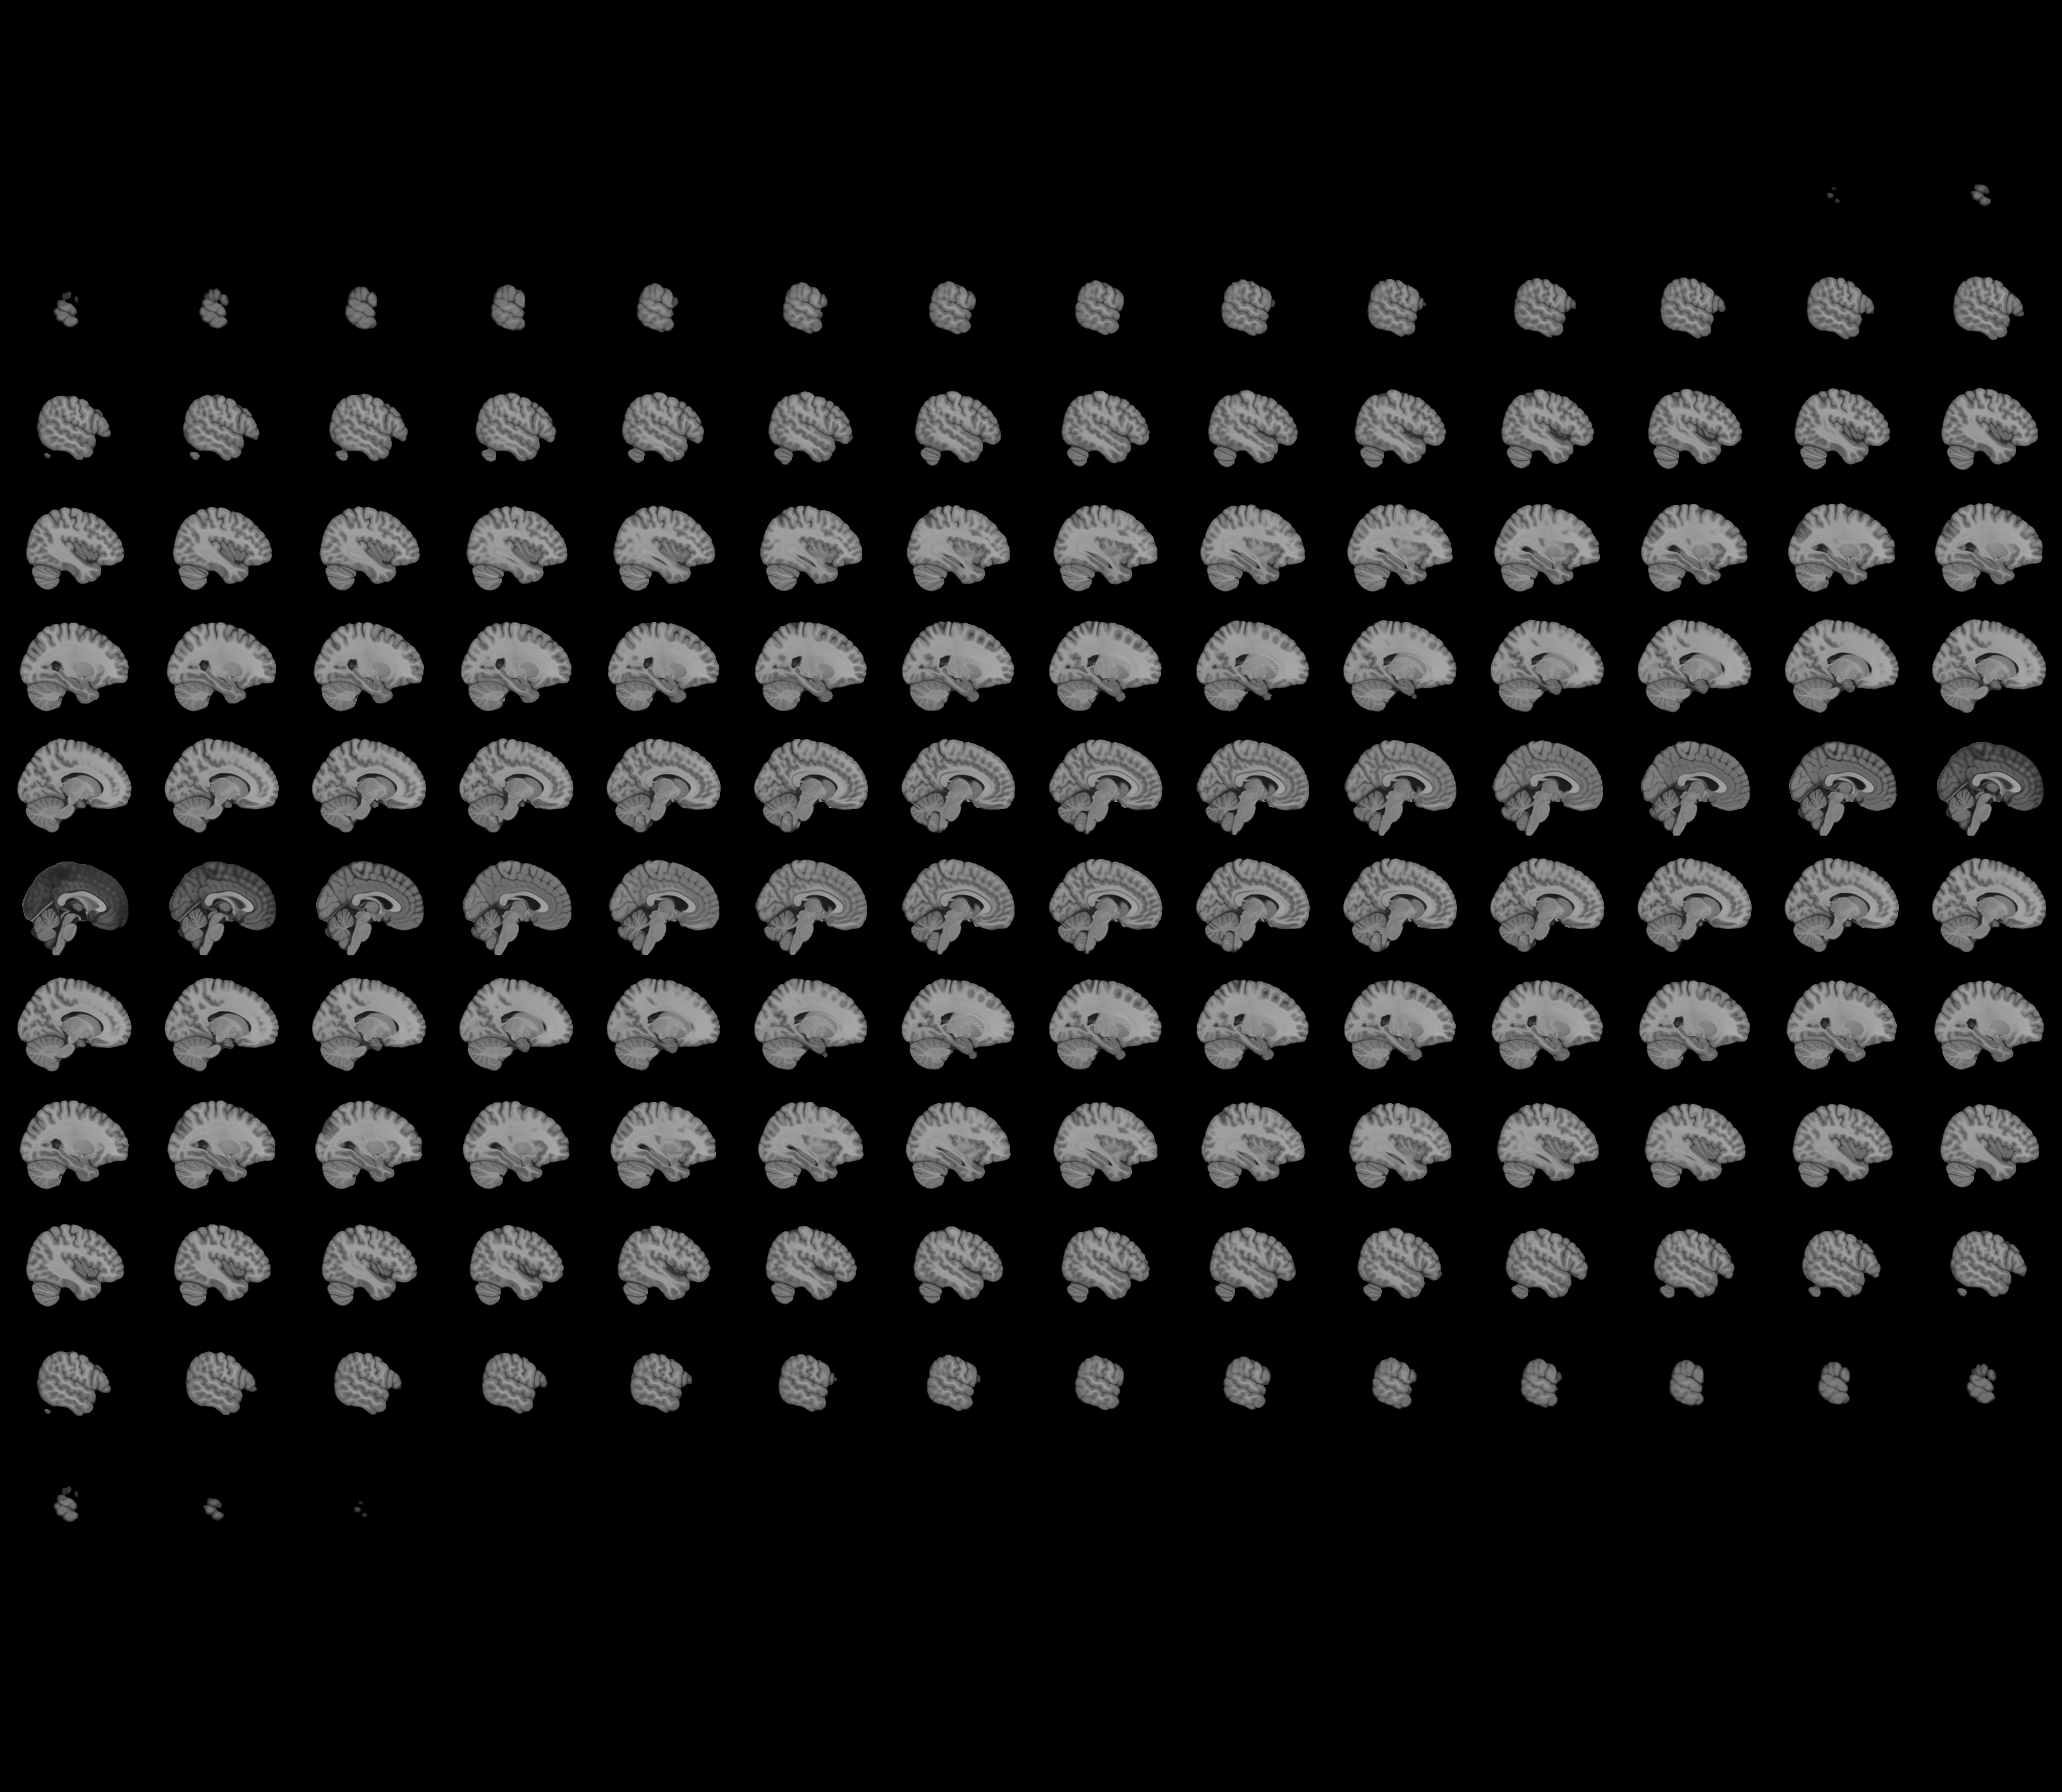
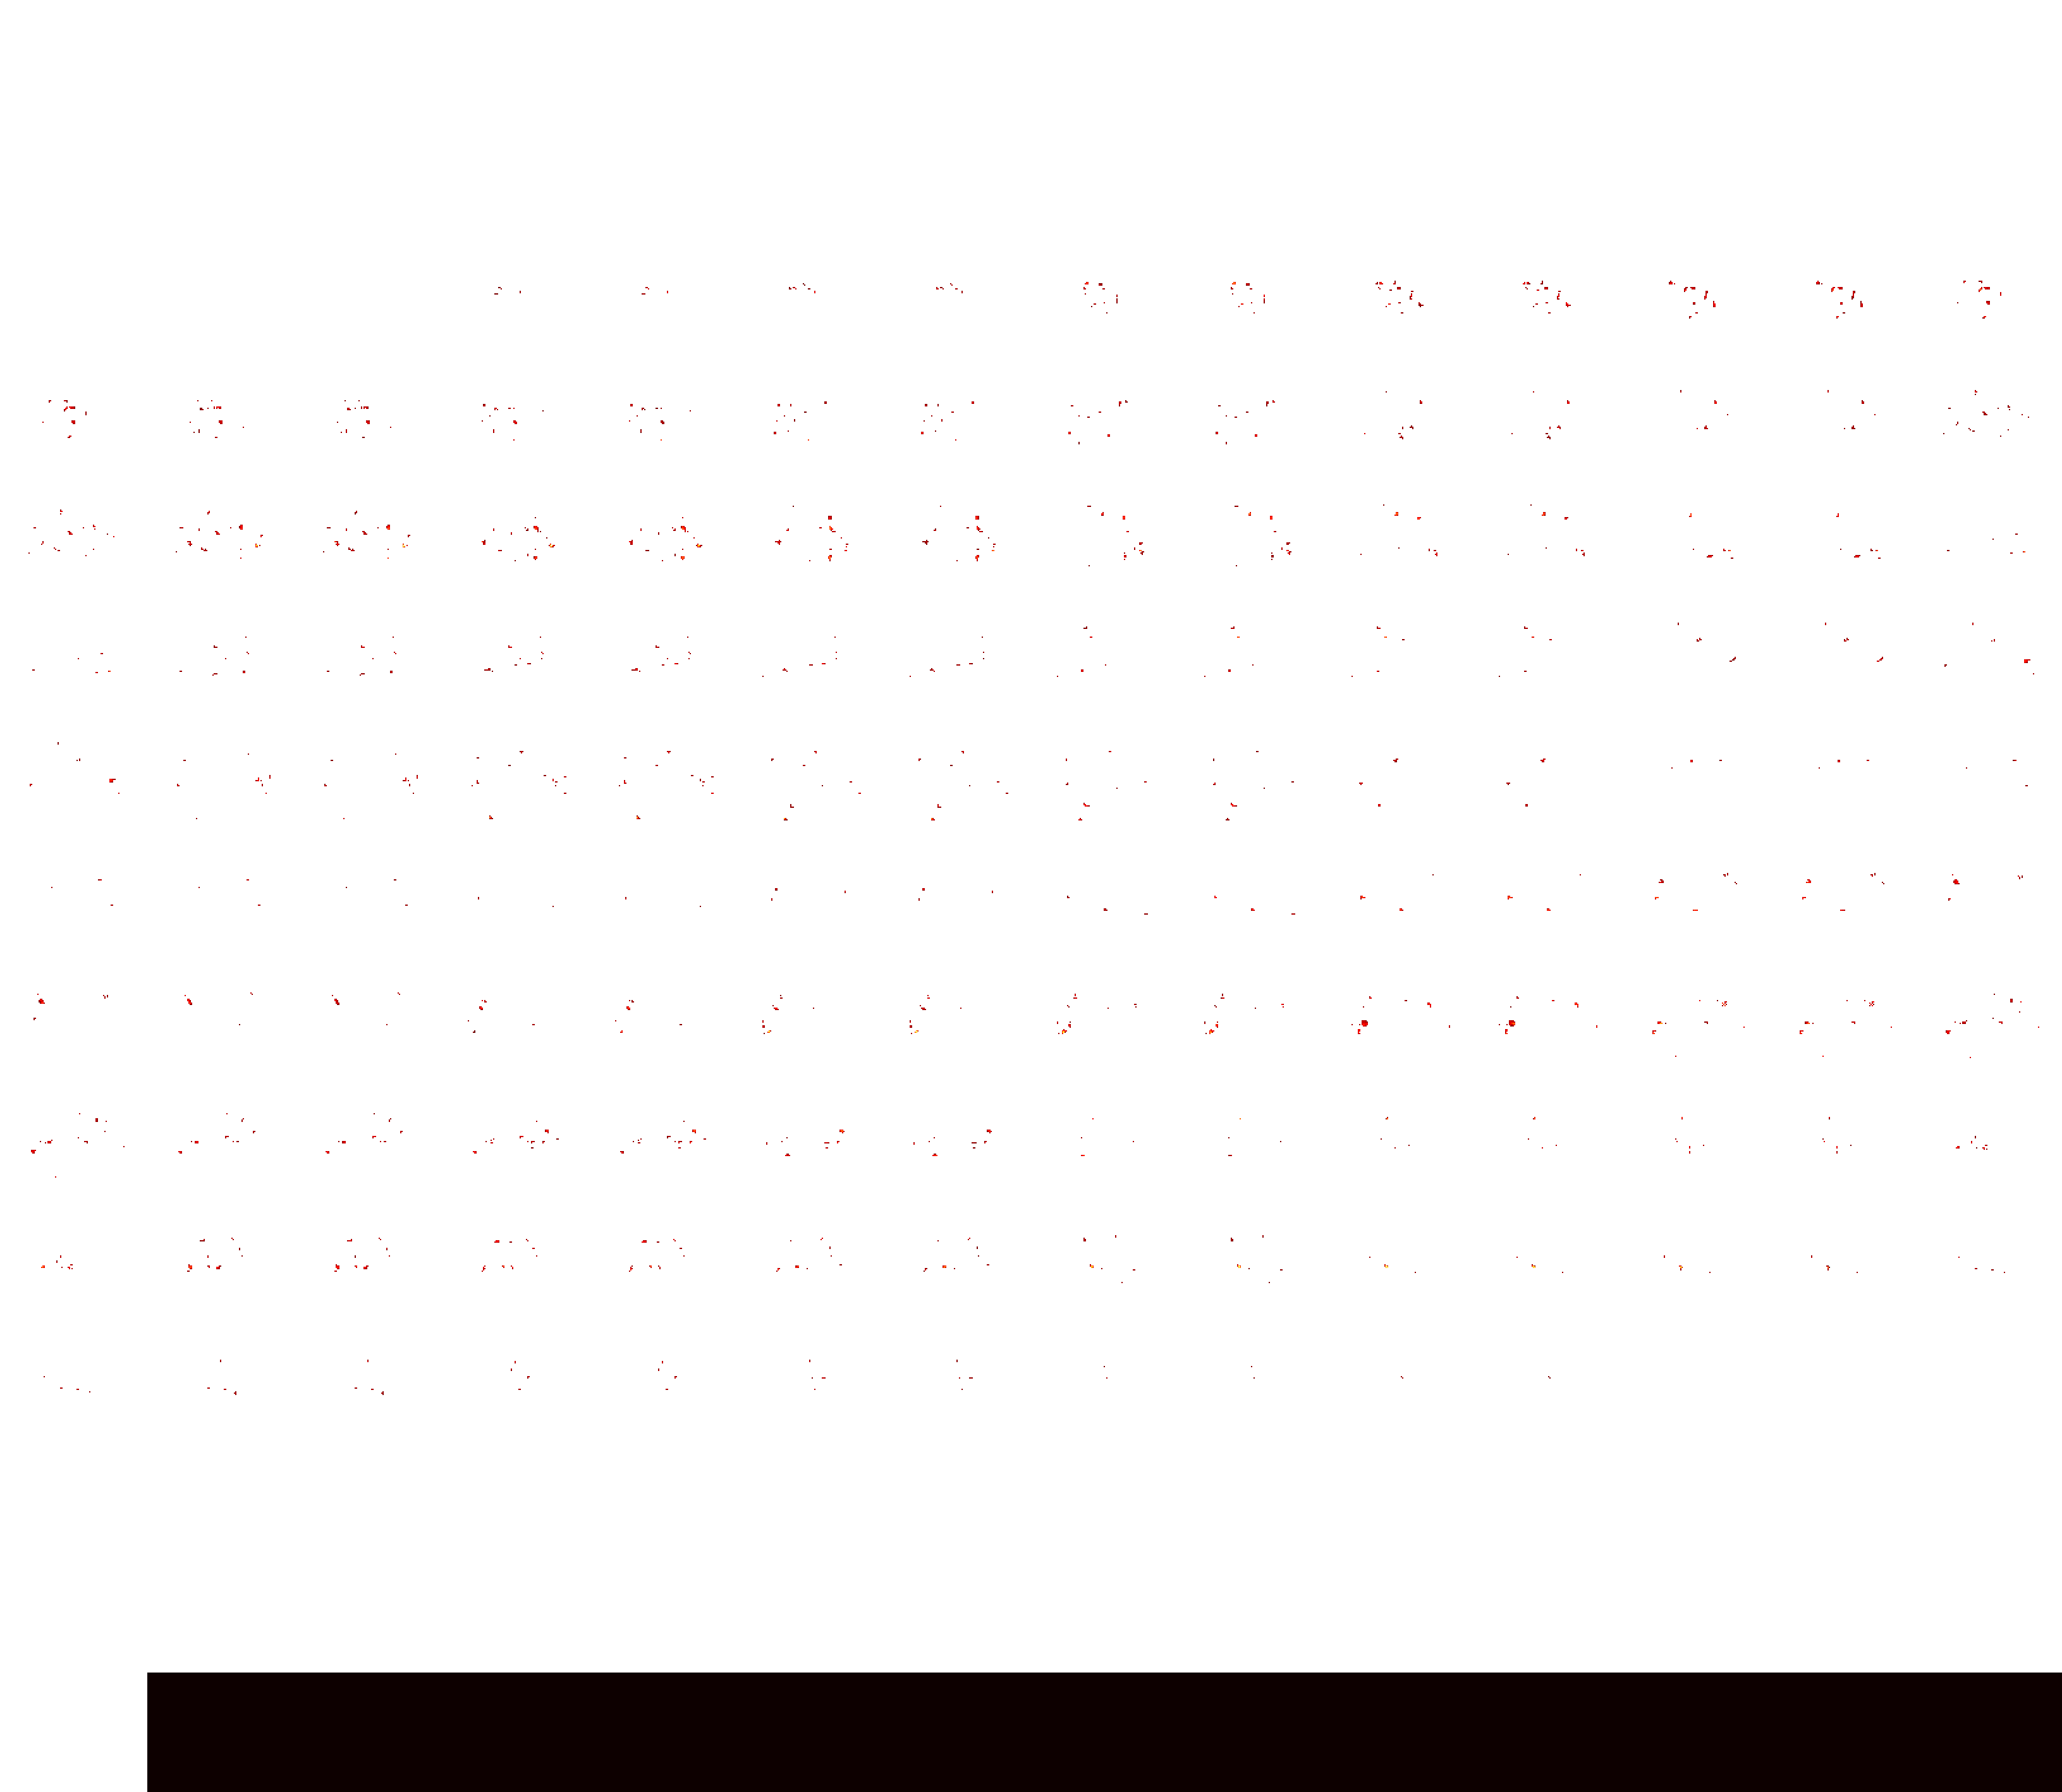

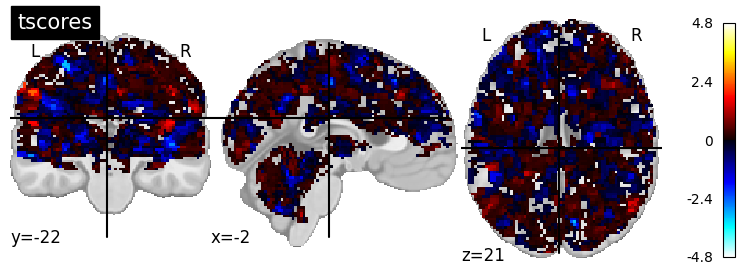

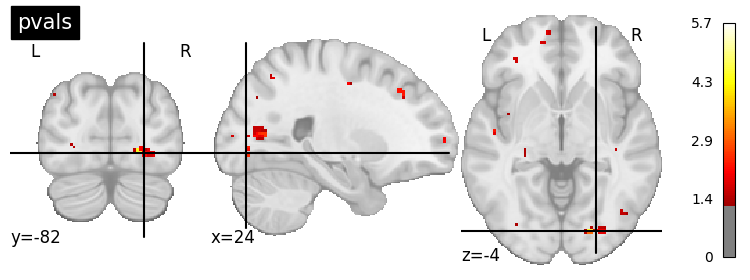

In [16]:
nplot.plot_stat_map(t_score_img_frem_comms, title='tscores')
nplot.plot_stat_map(neg_log_10_comms, threshold=-np.log10(0.05), title='pvals')
nplot.view_img(neg_log_10_comms, threshold=-np.log10(0.05), title='pvals')

#### Extract regions that are signficant predictors

In [17]:
if 'frem_svr_ADOS_Communication_sig_predictors.csv' in os.listdir(ml_dir):
    frem_predictors_df_comms = load_mvpa_predictors(f'{ml_dir}/frem_svr_ADOS_Communication_sig_predictors.csv')
else:
    frem_predictors_comms = get_clusters_table(neg_log_10_comms, stat_threshold=-np.log10(0.05))
    frem_predictors_comms['pval'] = 10 ** -frem_predictors_comms['Peak Stat'].values
    coords_comms = frem_predictors_comms[['X', 'Y', 'Z']]
    beta_t_comms = extract(coords_comms, r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'], t_score_img_frem_comms)
    frem_predictors_df_comms = pd.concat((frem_predictors_comms, beta_t_comms), axis=1).drop('Peak Stat', axis=1)
    frem_predictors_df_comms = predictors_df(frem_predictors_df_comms, frem_predictors_df_comms[['X', 'Y', 'Z']])
    frem_predictors_df_comms.to_csv(f'{ml_dir}/frem_svr_ADOS_Communication_sig_predictors.csv')

#### See if differences found from second level are significant predictors 

In [18]:
for task in ['happy', 'eft', 'fear']:
    try: 
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'interaction_clusters.csv'))
    except Exception:
        cluster_df = pd.read_csv(os.path.join(config(task), '2ndlevel', 'time_clusters.csv'))
    coords = cluster_df[['peak_x', 'peak_y', 'peak_z']]
    betas_df_stereo = extract(coords, r2_models['frem_svr_ADOS_sterotyped_and_repetititve'].coef_img_['beta'], t_score_img_frem_stereo )
    betas_df_comms = extract(coords, r2_models['frem_svr_ADOS_Communication'].coef_img_['beta'], t_score_img_frem_comms)
    pval_stero = NiftiSpheresMasker((coords.values)).fit_transform(pval_img_stereo)
    pval_comms = NiftiSpheresMasker((coords.values)).fit_transform(pval_img_comms)
    betas_df_stereo['pval'] = pd.Series(pval_stero.ravel())
    betas_df_comms['pval'] = pd.Series(pval_comms.ravel())
    display_df = cluster_df[['harvard_oxford']]
    if task == 'happy':
        display_df = cluster_df[['aal']]
    cluster_data = pd.concat((display_df, 
                             betas_df_stereo.rename(columns={'beta': 'beta_stereo', 
                                                             't_score': 'tscore_stereo',
                                                             'pval': 'pval_stereo'}), 
                             betas_df_comms.rename(columns={'beta': 'beta_comms',
                                                            't_score': 't_score_comms',
                                                            'pval': 'pval_comms'})), axis=1)
    cluster_data['BFB_comms'] = cluster_data['pval_comms'].apply(lambda p: bayes_factor_upper_bound(p)['BFB'])
    cluster_data['BFB_stereo'] = cluster_data['pval_stereo'].apply(lambda p: bayes_factor_upper_bound(p)['BFB'])
    display(task, cluster_data)

'happy'

aal  beta_stereo  tscore_stereo  \
0  75.00% Vermis_4_5; 25.00% Cerebelum_4_5_L     0.000055       0.201962   

   pval_stereo  beta_comms  t_score_comms  pval_comms  BFB_comms  BFB_stereo  
0     0.839946   -0.000115      -0.531096    0.595352  -1.191509   -2.511104

'eft'

harvard_oxford  beta_stereo  \
0  72.73% Right_Frontal_Operculum_Cortex; 27.27% ...    -0.000059   
1                         100.00% Right_Frontal_Pole     0.000061   
2                     100.00% Right_Planum_Temporale     0.000036   
3                              100.00% Right_Putamen     0.000060   
4                      100.00% Left_Precentral_Gyrus    -0.000034   
5                      100.00% Left_Precentral_Gyrus     0.000000   

   tscore_stereo  pval_stereo  beta_comms  t_score_comms  pval_comms  \
0      -0.077689     0.938075    0.000226       0.344779    0.730261   
1       0.142857     0.886403   -0.000012      -0.245980    0.805698   
2       0.142857     0.886403    0.000000       0.000000    0.000000   
3       0.175609     0.860601   -0.000006      -0.025748    0.979458   
4      -0.142857     0.886403   -0.000580      -0.834905    0.403771   
5       0.000000     0.000000   -0.000620      -0.955322    0.339415   

   BFB_comms  BFB_stereo  
0  -1.602540   -6.134738  
1  -2.113421   -3.441805  
2        NaN   -3.441805  
3 -18.095888   -2.847429  
4  -1.004633   -3.441805  
5   1.003083         NaN

'fear'

harvard_oxford  beta_stereo  \
0  40.37% Left_Frontal_Pole; 13.30% no_label; 10....     0.000029   

   tscore_stereo  pval_stereo    beta_comms  t_score_comms  pval_comms  \
0       0.075164     0.940085  5.301777e-07       0.001613    0.998713   

    BFB_comms  BFB_stereo  
0 -286.057662   -6.333633

In [19]:
frem_predictors_df_comms.sort_values(by='BFB', ascending=False).head()

Cluster ID     X     Y     Z  Cluster Size (mm3)      beta      pval  \
0           1 -40.5  39.5   9.5               128.0 -0.002801  0.000002   
7           2  51.5 -36.5   1.5               280.0 -0.002214  0.000003   
6           3  21.5 -82.5  -4.5               384.0 -0.002261  0.000023   
49          4 -10.5 -58.5 -42.5               128.0 -0.001515  0.000062   
30          6 -28.5  39.5  -0.5                16.0 -0.001637  0.000250   

             BFB          odds  null_proability  \
0   14284.630939  14285.630939           0.0070   
7    8756.783874   8757.783874           0.0114   
6    1475.229508   1476.229508           0.0677   
49    615.733309    616.733309           0.1621   
30    177.686070    178.686070           0.5596   

                                               labels  
0                                   Left Frontal Pole  
7   Right Superior Temporal Gyrus, posterior division  
6                                           Lingual_R  
49                                      Cerebelum_9_L  
30                                           no label